In [71]:
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from pyscf import dft, scf, gto, cc
from pyscfad import dft as dftad
from pyscfad import scf as scfad
from pyscfad import gto as gtoad
from pyscfad import cc as ccad
from ase.io import read
import equinox as eqx
import optax
import jax
import jax.numpy as jnp

from functools import partial
import pylibxc
import pyscfad.dft as dftad
from jax import custom_jvp
jax.config.update("jax_enable_x64", True) #Enables 64 bit precision
from ase.io import read

from xcquinox import net
from xcquinox import xc
from xcquinox.loss import compute_loss_mae
from xcquinox.train import Pretrainer, Optimizer
from xcquinox.utils import gen_grid_s, PBE_Fx, PBE_Fc, calculate_stats, lda_x, pw92c_unpolarized

In [2]:
g297 = read('/home/awills/Documents/Research/xcquinox/scripts/script_data/haunschild_g2/g2_97.traj', ':')

In [3]:
h2 = [i for i in g297 if i.get_chemical_formula() == 'H2'][0]

In [4]:
h2

Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...))

In [5]:
syms = h2.get_chemical_symbols()
pos = h2.positions
atstr = '; '.join(['{} {} {} {}'.format(syms[i], pos[i][0], pos[i][1], pos[i][2]) for i in range(len(syms))])
mol = gto.Mole(atom=atstr, basis='def2-tzvpd')
mol.verbose = 4
mf = dft.RKS(mol)
mf.xc = 'pbe,pbe'
mf.diis = None
mf.max_cycle = 25
mf.diis_start_cycle = 50
mf.grids.level = 5
mf.kernel(linear_mixing_alpha=0.3)

Initialize <pyscfad.gto.mole.Mole object at 0x7f6828445000> in <pyscfad.dft.rks.RKS object at 0x7f6828446440>
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


System: uname_result(system='Linux', node='aegis', release='5.15.0-139-generic', version='#149~20.04.1-Ubuntu SMP Wed Apr 16 08:29:56 UTC 2025', machine='x86_64')  Threads 20
Python 3.10.14 (main, Mar 21 2024, 16:24:04) [GCC 11.2.0]
numpy 1.26.4  scipy 1.11.4  h5py 3.11.0
Date: Sun Jul 20 12:50:48 2025
PySCF version 2.9.0
PySCF path  /home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 2
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 H      0.000000000000   0.000000000000   0.371395000000 AA    0.000000000000   0.000000000000   0.701834834033 Bohr   0.0
[INPUT]  2 H      0.000000000000   0.000000000000  -0.371395000000 AA    0.000000000000   0.0000000000

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute _enuc because it is not JSON-serializable
  warnings.warn(msg)


  HOMO = -0.426128445925796  LUMO = 0.0151459597741308
cycle= 1 E= -1.2392768795632  delta_E= -0.277  |g|= 4.62e-15  |ddm|= 0.466
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING SPECIFIED -- Using alternate order for matrix calculations
  HOMO = -0.389849011442173  LUMO = 0.0274400575140182
cycle= 2 E= -1.18249030867976  delta_E= 0.0568  |g|= 1.47e-14  |ddm|= 0.178
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING SPECIFIED -- Using alternate order for matrix calculations
  HOMO = -0.38497907633069  LUMO = 0.0290799291551159
cycle= 3 E= -1.17393479523424  delta_E= 0.00856  |g|= 4.87e-15  |ddm|= 0.108
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING SPECIFIED -- Using alternate order for matrix calculations
  HOMO = -0.383069137270172  LUMO = 0.0297201898268427
cycle= 4 E= -1.17043912620963  delta_E= 0.0035  |g|= 3.82e-15  |ddm|= 0.0729
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING SPECIFIED -- Using alternate order for matrix calculations
  HOMO = -0.382082357126969  LUM

Array(-1.16587383, dtype=float64)

In [6]:
syms = h2.get_chemical_symbols()
pos = h2.positions
atstr = '; '.join(['{} {} {} {}'.format(syms[i], pos[i][0], pos[i][1], pos[i][2]) for i in range(len(syms))])
mol = gto.Mole(atom=atstr, basis='def2-tzvpd')
mol.verbose = 4
mf = dft.RKS(mol)
mf.xc = 'pbe,pbe'
mf.max_cycle = 25
mf.diis_start_cycle = 50
mf.grids.level = 5
mf.kernel(linear_mixing_alpha=0.3)

System: uname_result(system='Linux', node='aegis', release='5.15.0-139-generic', version='#149~20.04.1-Ubuntu SMP Wed Apr 16 08:29:56 UTC 2025', machine='x86_64')  Threads 20
Python 3.10.14 (main, Mar 21 2024, 16:24:04) [GCC 11.2.0]
numpy 1.26.4  scipy 1.11.4  h5py 3.11.0
Date: Sun Jul 20 12:50:56 2025
PySCF version 2.9.0
PySCF path  /home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 2
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 H      0.000000000000   0.000000000000   0.371395000000 AA    0.000000000000   0.000000000000   0.701834834033 Bohr   0.0
[INPUT]  2 H      0.000000000000   0.000000000000  -0.371395000000 AA    0.000000000000   0.0000000000

Initialize <pyscfad.gto.mole.Mole object at 0x7f67905fb130> in <pyscfad.dft.rks.RKS object at 0x7f67905fb220>


tot grids = 47080
init E= -0.96274472276444
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING SPECIFIED -- Using alternate order for matrix calculations


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute _enuc because it is not JSON-serializable
  warnings.warn(msg)


  HOMO = -0.426128445925796  LUMO = 0.0151459597741308
cycle= 1 E= -1.2392768795632  delta_E= -0.277  |g|= 4.62e-15  |ddm|= 0.466
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING SPECIFIED -- Using alternate order for matrix calculations
  HOMO = -0.389849011442173  LUMO = 0.0274400575140182
cycle= 2 E= -1.18249030867976  delta_E= 0.0568  |g|= 1.47e-14  |ddm|= 0.178
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING SPECIFIED -- Using alternate order for matrix calculations
  HOMO = -0.38497907633069  LUMO = 0.0290799291551159
cycle= 3 E= -1.17393479523424  delta_E= 0.00856  |g|= 4.87e-15  |ddm|= 0.108
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING SPECIFIED -- Using alternate order for matrix calculations
  HOMO = -0.383069137270172  LUMO = 0.0297201898268427
cycle= 4 E= -1.17043912620963  delta_E= 0.0035  |g|= 3.82e-15  |ddm|= 0.0729
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING SPECIFIED -- Using alternate order for matrix calculations
  HOMO = -0.382082357126969  LUM

Array(-1.16587383, dtype=float64)

In [7]:
syms = h2.get_chemical_symbols()
pos = h2.positions
atstr = '; '.join(['{} {} {} {}'.format(syms[i], pos[i][0], pos[i][1], pos[i][2]) for i in range(len(syms))])
mol = gto.Mole(atom=atstr, basis='def2-tzvpd')
mol.verbose = 4
mf = dft.RKS(mol)
mf.xc = 'pbe,pbe'
mf.max_cycle = 25
mf.diis_start_cycle = 50
mf.grids.level = 5
mf.kernel()

System: uname_result(system='Linux', node='aegis', release='5.15.0-139-generic', version='#149~20.04.1-Ubuntu SMP Wed Apr 16 08:29:56 UTC 2025', machine='x86_64')  Threads 20
Python 3.10.14 (main, Mar 21 2024, 16:24:04) [GCC 11.2.0]
numpy 1.26.4  scipy 1.11.4  h5py 3.11.0
Date: Sun Jul 20 12:51:02 2025
PySCF version 2.9.0
PySCF path  /home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 2
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 H      0.000000000000   0.000000000000   0.371395000000 AA    0.000000000000   0.000000000000   0.701834834033 Bohr   0.0
[INPUT]  2 H      0.000000000000   0.000000000000  -0.371395000000 AA    0.000000000000   0.0000000000

Initialize <pyscfad.gto.mole.Mole object at 0x7f6828444910> in <pyscfad.dft.rks.RKS object at 0x7f6828446ad0>


tot grids = 47080
init E= -0.96274472276444
  HOMO = -0.426128445925795  LUMO = 0.0151459597741305


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute _enuc because it is not JSON-serializable
  warnings.warn(msg)


cycle= 1 E= -1.16449315048524  delta_E= -0.202  |g|= 0.0568  |ddm|= 0.466
  HOMO = -0.365016504092711  LUMO = 0.0364045808609649
cycle= 2 E= -1.16570674158481  delta_E= -0.00121  |g|= 0.0194  |ddm|= 0.0661
  HOMO = -0.386428280519907  LUMO = 0.0283460765480107
cycle= 3 E= -1.16585365812045  delta_E= -0.000147  |g|= 0.00673  |ddm|= 0.0233
  HOMO = -0.378891713464481  LUMO = 0.0311759662363151
cycle= 4 E= -1.16587121813695  delta_E= -1.76e-05  |g|= 0.00233  |ddm|= 0.00803
  HOMO = -0.381487834463789  LUMO = 0.0301998242956252
cycle= 5 E= -1.16587332933089  delta_E= -2.11e-06  |g|= 0.000808  |ddm|= 0.00278
  HOMO = -0.380586510637871  LUMO = 0.0305385119448808
cycle= 6 E= -1.16587358266024  delta_E= -2.53e-07  |g|= 0.00028  |ddm|= 0.000965
  HOMO = -0.380898593498897  LUMO = 0.0304212155394291
cycle= 7 E= -1.16587361307895  delta_E= -3.04e-08  |g|= 9.7e-05  |ddm|= 0.000334
  HOMO = -0.380790434339829  LUMO = 0.0304618639995392
cycle= 8 E= -1.16587361673063  delta_E= -3.65e-09  |g|= 3.36e-

Array(-1.16587362, dtype=float64)

In [8]:
#reference energies:
#[H_TE, O_TE, H2O_AE] <- step 1
kjMol_to_H = 2625.5
refs1 = [-0.5, -75.0673, -974.94/kjMol_to_H]
#[Cl_TE, Cl2_AE, HF+F -> H+F2 barrier]
refs2 = [-460.148, -0.09454200500963746, 0.16920860069537955]
refs3 = refs1 + refs2

mol_params = {'H': {'atoms':['H'], 'coords': [[0,0,0]], 'spin':1, 'charge':0},
              'O': {'atoms':['O'], 'coords':[[0,0,0]], 'spin':2, 'charge':0},
              'H2O': {'atoms':['O','H','H'], 'coords':[[0,0,0],[0,-0.757,0.587],[0,0.757,0.587]], 'spin':0,'charge':0},
              'Cl':{'atoms':['Cl'], 'coords':[[0,0,0]], 'spin':1, 'charge':0},
              'Cl2':{'atoms':['Cl','Cl'], 'coords': [ [0,0,1.008241], [0,0,-1.008241] ], 'spin':0, 'charge':0},
              'HF2':{'atoms':['H', 'F', 'F'], 'coords':[ [0,0,-2.2312757],[0,0,-0.61621628],[0,0,0.8641358] ], 'spin':1, 'charge':0},
              'FH':{'atoms':['F', 'H'], 'coords':[ [0,0,0.09153813], [0,0,-0.82384424] ], 'spin':0, 'charge':0},
              'F':{'atoms':['F'], 'coords':[ [0,0,0] ], 'spin':1, 'charge':0}
             }
mol_dct = {k:0 for k in mol_params.keys()}
for sys in mol_dct.keys():
    atstr = ''
    for idx, at in enumerate(mol_params[sys]['atoms']):
        atstr += '{} {} {} {}\n'.format(at, *mol_params[sys]['coords'][idx])
    mol = gto.Mole(atom = atstr, charge = mol_params[sys]['charge'], spin = mol_params[sys]['spin'])
    mol.basis = 'dzvp'
    mol.build()
    mol.max_memory = 32000

    mol_dct[sys] = mol

mols1 = [mol_dct['H'], mol_dct['O'], mol_dct['H2O']]
mols2 = [mol_dct['Cl'], mol_dct['Cl2'], mol_dct['HF2'], mol_dct['FH'], mol_dct['F']]
mols3 = mols1+mols2

In [9]:
e_lin = []
for mol in mols1:
    print(20*'=')
    print(20*'-')
    print(mol.atom)
    mol.verbose = 4
    print(mol.spin)
    if mol.spin:
        mf = dft.UKS(mol)
    else:
        mf = dft.RKS(mol)
    mf.xc = 'pbe,pbe'
    mf.conv_tol = 1e-5
    # mf.max_cycle = 25
    mf.diis_start_cycle = 9999999999
    mf.grids.level = 4
    mf.kernel(linear_mixing_alpha=0.3)
    e_lin.append(mf.e_tot)
    print(20*'=')

--------------------
H 0 0 0

1
XC library pyscf.dft.libxc version 7.0.0
    S. Lehtola, C. Steigemann, M. J.T. Oliveira, and M. A.L. Marques.,  SoftwareX 7, 1–5 (2018)
XC functionals = pbe,pbe
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 77, 3865 (1996)
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 78, 1396 (1997)
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 77, 3865 (1996)
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 78, 1396 (1997)
radial grids: 
    Treutler-Ahlrichs [JCP 102, 346 (1995); DOI:10.1063/1.469408] (M4) radial grids
    
becke partition: Becke, JCP 88, 2547 (1988); DOI:10.1063/1.454033
pruning grids: <function nwchem_prune at 0x7f67b07bbd90>
grids dens level: 4
symmetrized grids: False
atomic radii adjust function: <function treutler_atomic_radii_adjust at 0x7f67b07ba4d0>
small_rho_cutoff = 1e-07
Set gradient conv threshold to 0.00316228
tot grids = 15712
init E= -0.444008054813723
LINEAR MIX

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


cycle= 1 E= -0.44859376505469  delta_E= -0.00459  |g|= 3.12e-17  |ddm|= 0.472
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING SPECIFIED -- Using alternate order for matrix calculations
cycle= 2 E= -0.467101539675951  delta_E= -0.0185  |g|= 1.55e-17  |ddm|= 0.173
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING SPECIFIED -- Using alternate order for matrix calculations
cycle= 3 E= -0.476058400462117  delta_E= -0.00896  |g|= 1.41e-18  |ddm|= 0.104
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING SPECIFIED -- Using alternate order for matrix calculations
cycle= 4 E= -0.481654671791573  delta_E= -0.0056  |g|= 7.76e-17  |ddm|= 0.0698
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING SPECIFIED -- Using alternate order for matrix calculations
cycle= 5 E= -0.485682182176589  delta_E= -0.00403  |g|= 4.98e-17  |ddm|= 0.0488
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING SPECIFIED -- Using alternate order for matrix calculations
cycle= 6 E= -0.488702964829824  delta_E= -0.00302  

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


  alpha nocc = 5  HOMO = -0.324034610270602  LUMO = 0.493060392921129

WARN: beta  nocc = 3  HOMO -0.324034610270602 >= LUMO -0.324034610270602


WARN: system HOMO -0.324034610270602 >= system LUMO -0.324034610270602

cycle= 1 E= -74.8339778433181  delta_E= 0.0861  |g|= 2.76e-15  |ddm|= 0.854
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING SPECIFIED -- Using alternate order for matrix calculations
  alpha nocc = 5  HOMO = -0.328510094610952  LUMO = 0.46584370064746
  beta  nocc = 3  HOMO = -0.300694359031708  LUMO = -0.288231850071901
cycle= 2 E= -75.0777125885972  delta_E= -0.244  |g|= 1.9e-15  |ddm|= 0.353
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING SPECIFIED -- Using alternate order for matrix calculations
  alpha nocc = 5  HOMO = -0.323092782687585  LUMO = 0.462932153109518
  beta  nocc = 3  HOMO = -0.288072524875821  LUMO = -0.268501097961729
cycle= 3 E= -75.0163702130113  delta_E= 0.0613  |g|= 1.76e-15  |ddm|= 0.217
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING 

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


  HOMO = -0.396152344119948  LUMO = 0.00929061867344708
cycle= 1 E= -79.7060675197705  delta_E= -3.4  |g|= 7.51e-15  |ddm|= 1.29
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING SPECIFIED -- Using alternate order for matrix calculations
  HOMO = -0.196134743795981  LUMO = 0.0499663010854549
cycle= 2 E= -73.9335085907085  delta_E= 5.77  |g|= 7.32e-15  |ddm|= 0.85
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING SPECIFIED -- Using alternate order for matrix calculations
  HOMO = -0.271635370792332  LUMO = 0.0295224387183841
cycle= 3 E= -76.6948833495778  delta_E= -2.76  |g|= 4.46e-15  |ddm|= 0.342
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING SPECIFIED -- Using alternate order for matrix calculations
  HOMO = -0.259186407919165  LUMO = 0.0330252690996675
cycle= 4 E= -76.3904740538518  delta_E= 0.304  |g|= 4.64e-15  |ddm|= 0.24
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING SPECIFIED -- Using alternate order for matrix calculations
  HOMO = -0.256534476722749  LUMO = 0.03

In [10]:
e_def = []
for mol in mols1:
    print(20*'=')
    print(20*'-')
    print(mol.atom)
    mol.verbose = 4
    print(mol.spin)
    if mol.spin:
        mf = dft.UKS(mol)
    else:
        mf = dft.RKS(mol)
    mf.xc = 'pbe,pbe'
    mf.conv_tol = 1e-5
    # mf.max_cycle = 25
    mf.diis_start_cycle = 9999999999
    mf.grids.level = 4
    mf.kernel()
    e_def.append(mf.e_tot)
    print(20*'=')

--------------------
H 0 0 0

1
XC library pyscf.dft.libxc version 7.0.0
    S. Lehtola, C. Steigemann, M. J.T. Oliveira, and M. A.L. Marques.,  SoftwareX 7, 1–5 (2018)
XC functionals = pbe,pbe
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 77, 3865 (1996)
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 78, 1396 (1997)
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 77, 3865 (1996)
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 78, 1396 (1997)
radial grids: 
    Treutler-Ahlrichs [JCP 102, 346 (1995); DOI:10.1063/1.469408] (M4) radial grids
    
becke partition: Becke, JCP 88, 2547 (1988); DOI:10.1063/1.454033
pruning grids: <function nwchem_prune at 0x7f67b07bbd90>
grids dens level: 4
symmetrized grids: False
atomic radii adjust function: <function treutler_atomic_radii_adjust at 0x7f67b07ba4d0>
small_rho_cutoff = 1e-07
Set gradient conv threshold to 0.00316228
tot grids = 15712
init E= -0.444008054813723


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


cycle= 1 E= -0.495768334485472  delta_E= -0.0518  |g|= 0.0425  |ddm|= 0.472
cycle= 2 E= -0.497680293519902  delta_E= -0.00191  |g|= 0.0027  |ddm|= 0.0946
cycle= 3 E= -0.497687872049412  delta_E= -7.58e-06  |g|= 0.000203  |ddm|= 0.00595
Extra cycle  E= -0.49768791496599  delta_E= -4.29e-08  |g|= 1.51e-05  |ddm|= 0.000448
converged SCF energy = -0.49768791496599  <S^2> = 0.75  2S+1 = 2
--------------------
O 0 0 0

2
XC library pyscf.dft.libxc version 7.0.0
    S. Lehtola, C. Steigemann, M. J.T. Oliveira, and M. A.L. Marques.,  SoftwareX 7, 1–5 (2018)
XC functionals = pbe,pbe
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 77, 3865 (1996)
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 78, 1396 (1997)
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 77, 3865 (1996)
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 78, 1396 (1997)
radial grids: 
    Treutler-Ahlrichs [JCP 102, 346 (1995); DOI:10.1063/1.469408] (M4) radial gr

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


cycle= 1 E= -74.9910950429718  delta_E= -0.071  |g|= 0.0776  |ddm|= 0.854
  alpha nocc = 5  HOMO = -0.330047547724511  LUMO = 0.44941290460207
  beta  nocc = 3  HOMO = -0.284062454493327  LUMO = -0.252586638957968
cycle= 2 E= -74.9946836715805  delta_E= -0.00359  |g|= 0.0308  |ddm|= 0.105
  alpha nocc = 5  HOMO = -0.30541004909646  LUMO = 0.463934931711597
  beta  nocc = 3  HOMO = -0.25934663678523  LUMO = -0.223341018361199
cycle= 3 E= -74.9946698859864  delta_E= 1.38e-05  |g|= 0.0314  |ddm|= 0.0567
  alpha nocc = 5  HOMO = -0.331712426078995  LUMO = 0.45023858278488
  beta  nocc = 3  HOMO = -0.284845532165108  LUMO = -0.247901437801405
cycle= 4 E= -74.994621724201  delta_E= 4.82e-05  |g|= 0.0329  |ddm|= 0.0588
  alpha nocc = 5  HOMO = -0.30398263961015  LUMO = 0.464795052292753
  beta  nocc = 3  HOMO = -0.257491124562418  LUMO = -0.221434834306098
cycle= 5 E= -74.9945511836023  delta_E= 7.05e-05  |g|= 0.0352  |ddm|= 0.0622
  alpha nocc = 5  HOMO = -0.33337197187718  LUMO = 0.44942771

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


cycle= 2 E= -75.9969914989078  delta_E= 0.255  |g|= 1.33  |ddm|= 1.37
  HOMO = -0.683684076841339  LUMO = -0.054419644491819
cycle= 3 E= -75.5117201953283  delta_E= 0.485  |g|= 1.94  |ddm|=  2.2
  HOMO = 0.163023389907445  LUMO = 0.20425450580736
cycle= 4 E= -73.8896799843902  delta_E= 1.62  |g|= 3.06  |ddm|= 4.14
  HOMO = -1.52460246781813  LUMO = -0.214379452085613
cycle= 5 E= -73.7269986569405  delta_E= 0.163  |g|= 2.93  |ddm|= 4.96
  HOMO = 0.325102050087472  LUMO = 0.337546679108964
cycle= 6 E= -71.4092675593703  delta_E= 2.32  |g|= 3.67  |ddm|= 9.53
  HOMO = -2.09362986551626  LUMO = -0.346547142356095
cycle= 7 E= -73.0366997587514  delta_E= -1.63  |g|= 3.08  |ddm|=  9.7
  HOMO = 0.353415779210066  LUMO = 0.378227461540496
cycle= 8 E= -70.4848162109511  delta_E= 2.55  |g|= 3.74  |ddm|= 12.4
  HOMO = -2.2581451680575  LUMO = -0.40638379119597
cycle= 9 E= -72.866458098836  delta_E= -2.38  |g|= 3.11  |ddm|= 12.4
  HOMO = 0.358556954625864  LUMO = 0.390101153094835
cycle= 10 E= -70.3

In [11]:
for idx, i in enumerate(e_lin):
    print(10*'-')
    print(mols3[idx].atom)
    print(abs(e_def[idx]-e_lin[idx]))
    print(10*'-')

----------
H 0 0 0

2.396200460275111e-10
----------
----------
O 0 0 0

0.060330209726018325
----------
----------
O 0 0 0
H 0 -0.757 0.587
H 0 0.757 0.587

6.0353130259613295
----------


We can see that the linear mixing scheme leads to converged results for all H, O, and H2O molecules, whereas the default DIIS scheme does not converge within 50 steps for O and H2O.

In [12]:
syms = h2.get_chemical_symbols()
pos = h2.positions
atstr = '; '.join(['{} {} {} {}'.format(syms[i], pos[i][0], pos[i][1], pos[i][2]) for i in range(len(syms))])
mol = gto.Mole(atom=atstr, basis='def2-tzvpd')
mol.verbose = 4
mf = dft.RKS(mol)
mf.xc = 'pbe,pbe'
mf.max_cycle = -1
mf.kernel()
mf.max_cycle=25
mf.diis_start_cycle = 50
mf.grids.level = 5
deriv_func = partial(mf.kernel, linear_mixing_alpha=0.3)
g = jax.grad(deriv_func)(mf.make_rdm1())

System: uname_result(system='Linux', node='aegis', release='5.15.0-139-generic', version='#149~20.04.1-Ubuntu SMP Wed Apr 16 08:29:56 UTC 2025', machine='x86_64')  Threads 20
Python 3.10.14 (main, Mar 21 2024, 16:24:04) [GCC 11.2.0]
numpy 1.26.4  scipy 1.11.4  h5py 3.11.0
Date: Sun Jul 20 12:52:02 2025
PySCF version 2.9.0
PySCF path  /home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 2
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 H      0.000000000000   0.000000000000   0.371395000000 AA    0.000000000000   0.000000000000   0.701834834033 Bohr   0.0
[INPUT]  2 H      0.000000000000   0.000000000000  -0.371395000000 AA    0.000000000000   0.0000000000

Initialize <pyscfad.gto.mole.Mole object at 0x7f676c2d52d0> in <pyscfad.dft.rks.RKS object at 0x7f676c2d63b0>


init E= -0.962744720439682
  HOMO = -0.426128444528908  LUMO = 0.0151459599272171
SCF not converged.
SCF energy = -0.962744720439682
XC library pyscf.dft.libxc version 7.0.0
    S. Lehtola, C. Steigemann, M. J.T. Oliveira, and M. A.L. Marques.,  SoftwareX 7, 1–5 (2018)
XC functionals = pbe,pbe
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 77, 3865 (1996)
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 78, 1396 (1997)
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 77, 3865 (1996)
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 78, 1396 (1997)
radial grids: 
    Treutler-Ahlrichs [JCP 102, 346 (1995); DOI:10.1063/1.469408] (M4) radial grids
    
becke partition: Becke, JCP 88, 2547 (1988); DOI:10.1063/1.454033
pruning grids: <function nwchem_prune at 0x7f67b07bbd90>
grids dens level: 5
symmetrized grids: False
atomic radii adjust function: <function treutler_atomic_radii_adjust at 0x7f67b07ba4d0>
small_rho_cutoff = 1e

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute _enuc because it is not JSON-serializable
  warnings.warn(msg)


  HOMO = -0.365016505227818  LUMO = 0.0364045813819
cycle= 1 E= -1.14041895401595  delta_E= 0.0241  |g|= 6.55e-15  |ddm|= 0.0661
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING SPECIFIED -- Using alternate order for matrix calculations
  HOMO = -0.377867792352748  LUMO = 0.0315008813776309
cycle= 2 E= -1.161235539905  delta_E= -0.0208  |g|= 9.13e-15  |ddm|= 0.0124
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING SPECIFIED -- Using alternate order for matrix calculations
  HOMO = -0.379423343737821  LUMO = 0.0309375145276563
cycle= 3 E= -1.1636926511177  delta_E= -0.00246  |g|= 3.7e-15  |ddm|= 0.0059
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING SPECIFIED -- Using alternate order for matrix calculations
  HOMO = -0.380040135481306  LUMO = 0.0307176386143726
cycle= 4 E= -1.16466159335873  delta_E= -0.000969  |g|= 5.71e-15  |ddm|= 0.00331
LINEAR MIXING SPECIFIED, ALPHA =  0.3
LINEAR MIXING SPECIFIED -- Using alternate order for matrix calculations
  HOMO = -0.380364493721904 

So we are able to access derivatives of the kernel function w.r.t. the input density matrix, which is what we want to show.

In [14]:
g.shape

(18, 18)

# Train a Network on a Maximally Representative (MR) Subset

These are located in `xcquinox/scripts/script_data/training_subsets`. Below I will use the `03` subset.

In [18]:
#load in the reference dataset
traj = read('/home/awills/Documents/Research/xcquinox/scripts/script_data/training_subsets/03/subat_ref.traj', ':')

In [19]:
for idx, at in enumerate(traj):
    print(10*"==")
    print(idx)
    print(at)
    print(at.info)
    print(10*"==")

0
Atoms(symbols='LiF', pbc=False, calculator=SinglePointCalculator(...))
{'LiF': True, 'name': 'Lithium fluoride', 'n_rad': 3, 'n_ang': 15, 'pol': False, 'target_energy': -0.22243004393513086, 'energy': -107.30594205098303, 'atomization': -0.22243004393513086, 'atomization_ev': -6.052629788935811, 'atomization_H': -0.22243004393513086, 'calc_energy': -107.30594205098303, 'e_calc': -107.30594205098303}
1
Atoms(symbols='ClH', pbc=False, calculator=SinglePointCalculator(...))
{'HCl': True, 'name': 'Hydrogen chloride', 'n_rad': 3, 'n_ang': 10, 'target_energy': -0.17123597861668197, 'energy': -460.4234539512034, 'atomization': -0.17123597861668197, 'atomization_ev': -4.659568315398828, 'atomization_H': -0.17123597861668197, 'calc_energy': -460.4234539512034, 'e_calc': -460.4234539512034}
2
Atoms(symbols='FH', pbc=False, calculator=SinglePointCalculator(...))
{'grid_level': 1, 'sym': False, 'sc': False, 'reaction': 'reactant', 'reference_height': None, 'spin': 0, 'target_energy': 0.0, 'energ

The reference values contained above are for:
- Atomization energies: $\mathrm{HCl}$ (index 1 - index 5 - index 8)  and $\mathrm{LiF}$ (index 0 - index 6 - index 7).
- Barrier height: $\mathrm{HF}+\mathrm{F} \to \mathrm{H} + \mathrm{F}_2$ (index 4 - index 3 - index 2)

### Pre-train SCAN

In [27]:
func_scan_x = pylibxc.LibXCFunctional("mgga_x_scan", "unpolarized")
func_scan_c = pylibxc.LibXCFunctional("mgga_c_scan", "unpolarized")

func_lda_x = pylibxc.LibXCFunctional("lda_x", "unpolarized")
func_lda_c = pylibxc.LibXCFunctional("lda_c_pw", "unpolarized")
g297 = read('/home/awills/Documents/Research/xcquinox/scripts/script_data/haunschild_g2/g2_97.traj', ':')
#we'll use LiF and LiH as our molecules to generate the relevant grids and descriptors
selected_mol_inds = [25, 26]
selected_mols = [g297[i] for i in selected_mol_inds]
for idx, at in enumerate(selected_mols):
    print(idx, at, at.info)
for idx, at in enumerate(selected_mols):
    print(idx, at)
    syms = at.get_chemical_symbols()
    pos = at.positions
    atstr = '; '.join(['{} {} {} {}'.format(syms[i], pos[i][0], pos[i][1], pos[i][2]) for i in range(len(syms))])
    mol = gto.Mole(atom=atstr, basis='def2-tzvpd')
    mf = dft.RKS(mol)
    mf.xc = 'scan,scan'
    mf.grids.level = 5
    mf.kernel()
    ao = dft.numint.eval_ao(mol, mf.grids.coords, deriv=2)
    dm = mf.make_rdm1()
    rho = dft.numint.eval_rho(mol, ao, dm, with_lapl=True, xctype='MGGA')
    if idx == 0:
        total_rho = rho
    else:
        total_rho = np.hstack([total_rho, rho])
total_rho_rho = total_rho[0, :]
total_rho_sigma = total_rho[1, :]**2 + total_rho[2, :]**2 + total_rho[3, :]**2
total_rho_lapl = total_rho[4, :]
total_rho_tau = total_rho[5, :]
total_rho_inp = np.vstack([total_rho_rho, total_rho_sigma, total_rho_lapl, total_rho_tau])
pylibxc_inp = {'rho': total_rho_rho,
               'sigma': total_rho_sigma,
               'lapl': total_rho_lapl,
               'tau': total_rho_tau
              }
ref_scan_x = func_scan_x.compute(pylibxc_inp)
ref_scan_c = func_scan_c.compute(pylibxc_inp)

ref_lda_x = func_lda_x.compute(pylibxc_inp)
ref_lda_c = func_lda_c.compute(pylibxc_inp)

ref_scan_Fx = (ref_scan_x['zk']/ref_lda_x['zk'])[0]
ref_scan_Fc = (ref_scan_c['zk']/ref_lda_c['zk'])[0]
#set up training/test indices
num_pts = total_rho_rho.shape[0]
inds = np.arange(num_pts)

Ntrain = int(0.85*num_pts)
Ntest = num_pts - Ntrain
np.random.seed(12345)
train_inds = np.random.choice(inds, size=Ntrain, replace=False)
test_inds = [i for i in inds if i not in train_inds]

train_pts = total_rho_inp[:, train_inds]
test_pts = total_rho_inp[:, test_inds]
train_ref_Fx = ref_scan_Fx[train_inds]
train_ref_Fc = ref_scan_Fc[train_inds]

test_ref_Fx = ref_scan_Fx[test_inds]
test_ref_Fc = ref_scan_Fc[test_inds]
#sigma-based networks
s_scan_fx = net.MGGA_FxNet_sigma(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)
s_scan_fc = net.MGGA_FcNet_sigma(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)
s_scan_fx_tr = net.MGGA_FxNet_sigma_transform(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)
s_scan_fc_tr = net.MGGA_FcNet_sigma_transform(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)

0 Atoms(symbols='LiF', pbc=False, calculator=SinglePointCalculator(...)) {'LiF': True, 'name': 'Lithium fluoride'}
1 Atoms(symbols='LiH', pbc=False, calculator=SinglePointCalculator(...)) {'LiH': True, 'name': 'Lithium hydride'}
0 Atoms(symbols='LiF', pbc=False, calculator=SinglePointCalculator(...))


Initialize <pyscf.gto.mole.Mole object at 0x7f66ec640a30> in <pyscf.dft.rks.RKS object at 0x7f676c35be20>


converged SCF energy = -107.434907718281
1 Atoms(symbols='LiH', pbc=False, calculator=SinglePointCalculator(...))


Initialize <pyscf.gto.mole.Mole object at 0x7f672c747d60> in <pyscf.dft.rks.RKS object at 0x7f66ec5bc0d0>


converged SCF energy = -8.06738140525756


In [31]:
OPT_INIT_LR = 1e-2
OPT_END_LR = 1e-6
OPTSTEPS = 5000
OPTDECAYBEGIN = 1000
# OPTDECAYRATE = 0.95
scheduler = optax.linear_schedule(
    init_value = OPT_INIT_LR,
    transition_steps = OPTSTEPS-OPTDECAYBEGIN,
    transition_begin = OPTDECAYBEGIN,
    end_value = OPT_END_LR,
)

#create optimizers
optimizer = optax.chain(
    optax.adam(learning_rate=scheduler)
)
#train points shape mismatch -- typical shape vmap expects is (Npts, Ninputs), but eval_rho gives us the opposite shape.
pt_scan_fx = Pretrainer(model = s_scan_fx, optim = optimizer, inputs = train_pts.T, ref = train_ref_Fx, loss = compute_loss_mae, steps = OPTSTEPS)
pt_scan_fc = Pretrainer(model = s_scan_fc, optim = optimizer, inputs = train_pts.T, ref = train_ref_Fc, loss = compute_loss_mae, steps = OPTSTEPS)

pt_scan_fxt = Pretrainer(model = s_scan_fx_tr, optim = optimizer, inputs = train_pts.T, ref = train_ref_Fx, loss = compute_loss_mae, steps = OPTSTEPS)
pt_scan_fct = Pretrainer(model = s_scan_fc_tr, optim = optimizer, inputs = train_pts.T, ref = train_ref_Fc, loss = compute_loss_mae, steps = OPTSTEPS)

nmx, nlx = pt_scan_fx()
nmc, nlc = pt_scan_fc()

nmxt, nlxt = pt_scan_fxt()
nmct, nlct = pt_scan_fct()

Epoch 0: Loss = 0.2791494530679824
Epoch 100: Loss = 0.030284336154639054
Epoch 200: Loss = 0.04872902067657029
Epoch 300: Loss = 0.057494576277655265
Epoch 400: Loss = 0.030087946056233
Epoch 500: Loss = 0.10719643096035955
Epoch 600: Loss = 0.04184734714492161
Epoch 700: Loss = 0.02412509251499217
Epoch 800: Loss = 0.02882959391644887
Epoch 900: Loss = 0.03451121224677546
Epoch 1000: Loss = 0.058928512120299086
Epoch 1100: Loss = 0.02927775743062551
Epoch 1200: Loss = 0.03337167692730397
Epoch 1300: Loss = 0.06292305165913951
Epoch 1400: Loss = 0.0665818276619814
Epoch 1500: Loss = 0.05204845321651332
Epoch 1600: Loss = 0.02493801043211695
Epoch 1700: Loss = 0.06287827352375834
Epoch 1800: Loss = 0.0254799738192875
Epoch 1900: Loss = 0.02651720654147895
Epoch 2000: Loss = 0.029210645949454384
Epoch 2100: Loss = 0.020498945428568584
Epoch 2200: Loss = 0.026585188115482793
Epoch 2300: Loss = 0.01742506068107047
Epoch 2400: Loss = 0.015044742315376504
Epoch 2500: Loss = 0.02615738691824

0.006258264038477861 0.010876392783914095
0.001078631486833241 0.0037728606678786463


Text(0.5, 0.98, 'Enhancement Factor Errors\nFunction Inputs: [$\\rho,\\sigma,\\nabla\\rho,\\tau$]\nNetwork Inputs: [$\\tilde{x}_0,\\tilde{x}_2,\\tilde{x}_3$]')

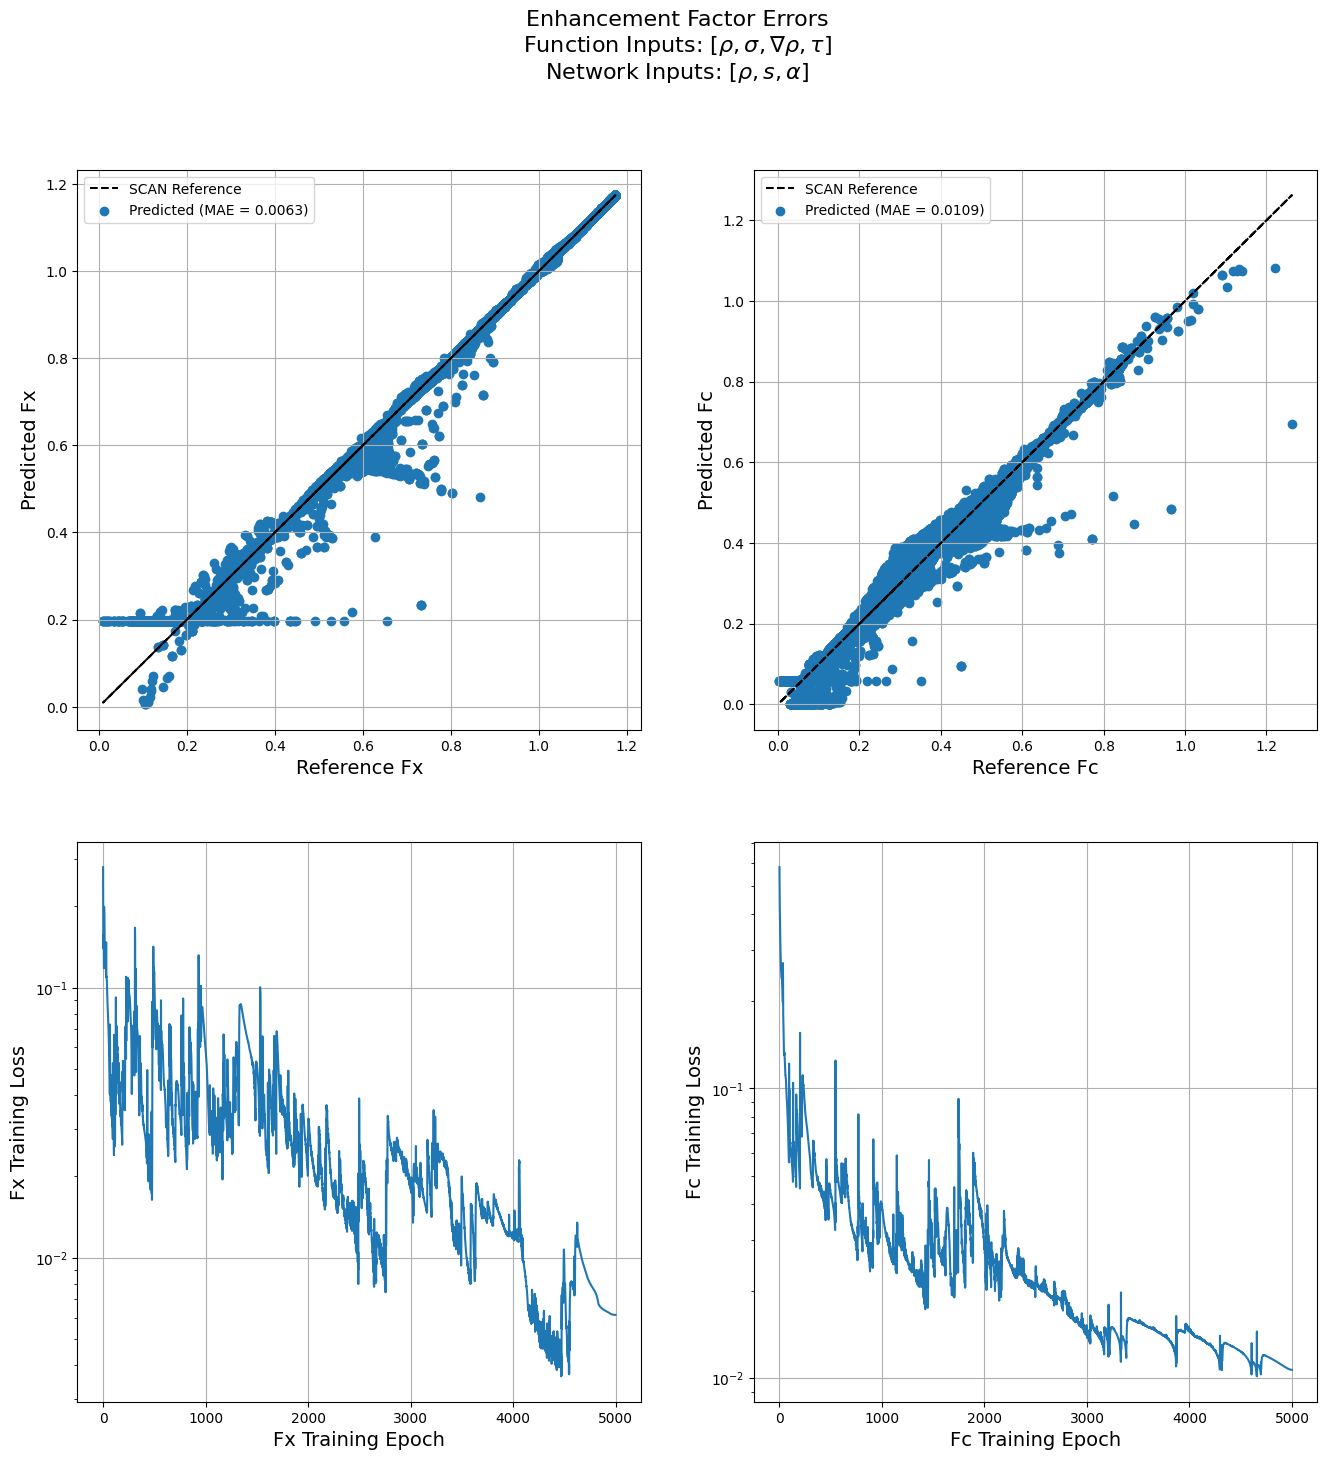

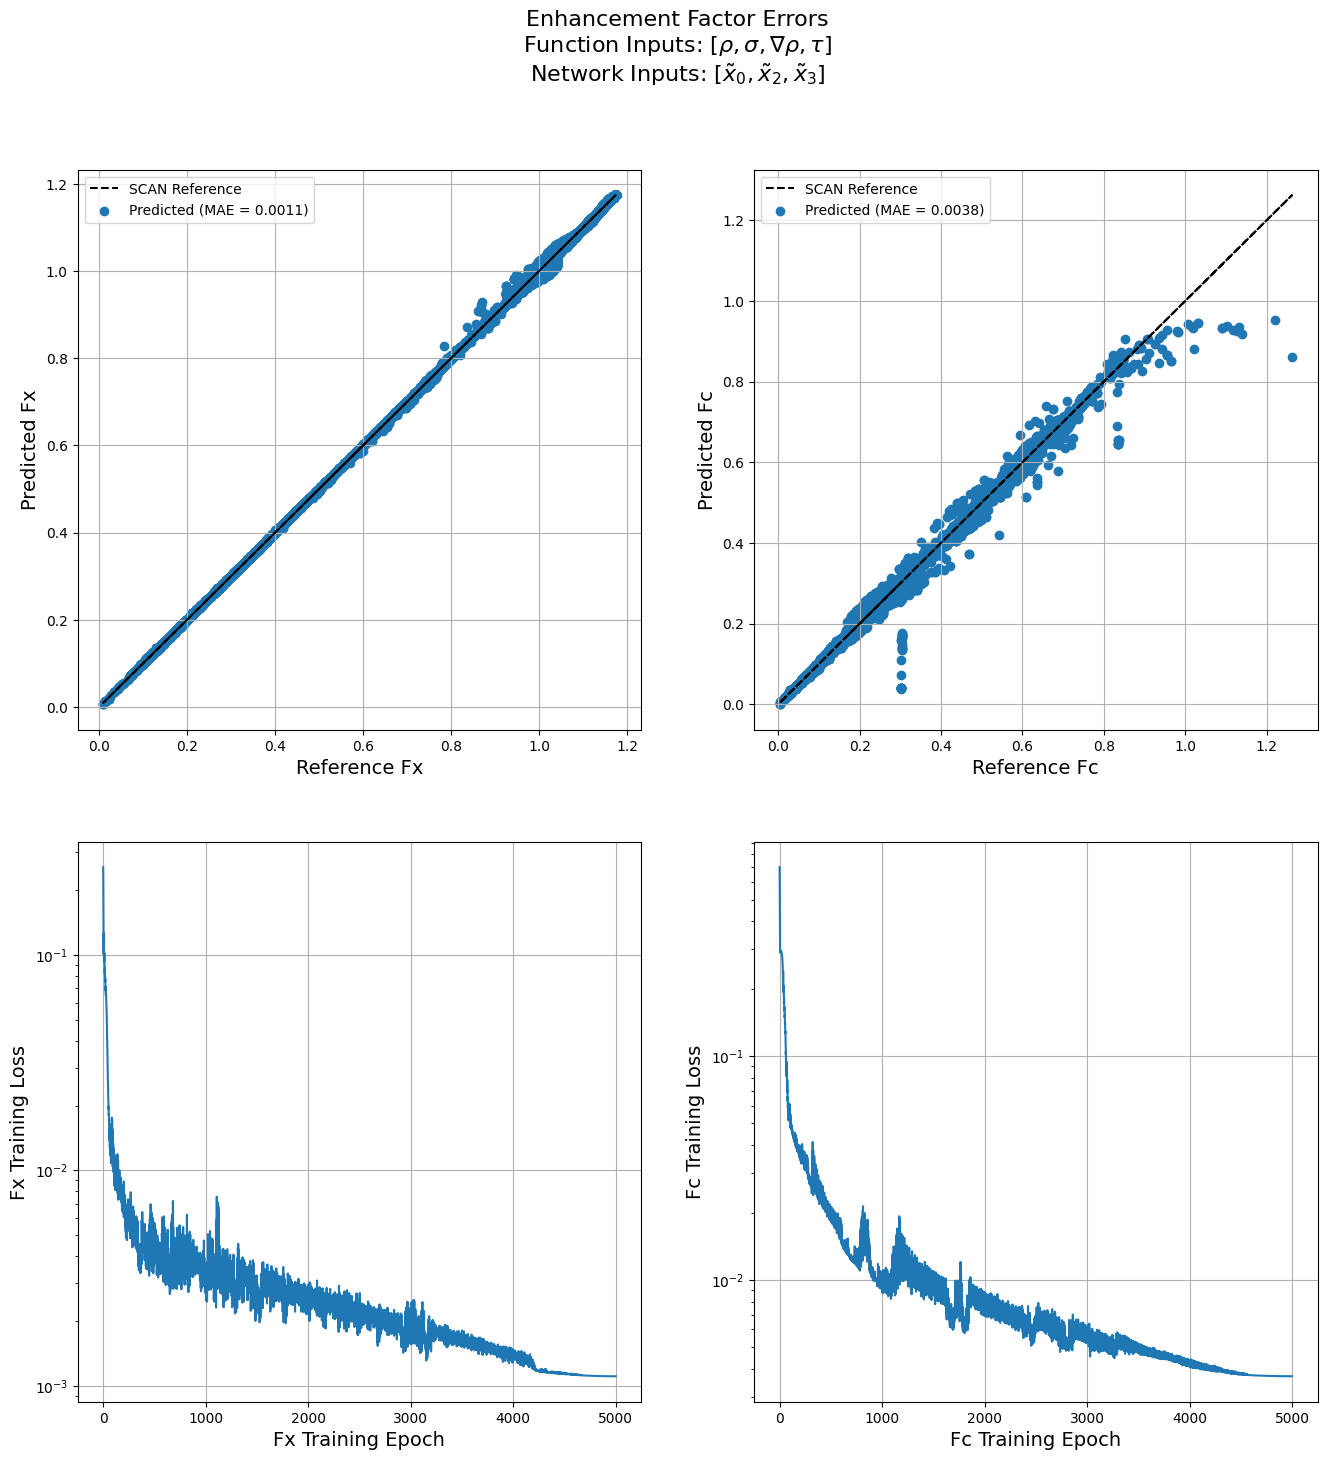

In [32]:
test_pred_fx = jax.vmap(nmx)(test_pts.T)
test_pred_fc = jax.vmap(nmc)(test_pts.T)

fx_mae = np.mean(abs(test_pred_fx - test_ref_Fx))
fc_mae = np.mean(abs(test_pred_fc - test_ref_Fc))
print(fx_mae, fc_mae)

test_pred_fxt = jax.vmap(nmxt)(test_pts.T)
test_pred_fct = jax.vmap(nmct)(test_pts.T)
 
fxt_mae = np.mean(abs(test_pred_fxt - test_ref_Fx))
fct_mae = np.mean(abs(test_pred_fct - test_ref_Fc))
print(fxt_mae, fct_mae)
f = plt.figure(figsize=(16,16))
axx = f.add_subplot(221)
axc = f.add_subplot(222)
axxl = f.add_subplot(223)
axcl = f.add_subplot(224)

axx.plot(test_ref_Fx, test_ref_Fx, 'k--', label='SCAN Reference')
axc.plot(test_ref_Fc, test_ref_Fc, 'k--', label='SCAN Reference')

axx.scatter(test_ref_Fx, test_pred_fx, label='Predicted (MAE = {:3.4f})'.format(fx_mae))
axc.scatter(test_ref_Fc, test_pred_fc, label='Predicted (MAE = {:3.4f})'.format(fc_mae))

axxl.plot(np.arange(0, OPTSTEPS), nlx)
axcl.plot(np.arange(0, OPTSTEPS), nlc)

axx.legend()
axc.legend()

axx.set_xlabel('Reference Fx', fontsize=14)
axx.set_ylabel('Predicted Fx', fontsize=14)
axxl.set_xlabel('Fx Training Epoch', fontsize=14)
axxl.set_ylabel('Fx Training Loss', fontsize=14)

axc.set_xlabel('Reference Fc', fontsize=14)
axc.set_ylabel('Predicted Fc', fontsize=14)
axcl.set_xlabel('Fc Training Epoch', fontsize=14)
axcl.set_ylabel('Fc Training Loss', fontsize=14)

axxl.set_yscale('log')
axcl.set_yscale('log')

axx.grid()
axc.grid()
axxl.grid()
axcl.grid()

plt.suptitle('Enhancement Factor Errors\nFunction Inputs: [$\\rho,\\sigma,\\nabla\\rho,\\tau$]\nNetwork Inputs: [$\\rho,s,\\alpha$]',fontsize=16)

f = plt.figure(figsize=(16,16))
axx = f.add_subplot(221)
axc = f.add_subplot(222)
axxl = f.add_subplot(223)
axcl = f.add_subplot(224)

axx.plot(test_ref_Fx, test_ref_Fx, 'k--', label='SCAN Reference')
axc.plot(test_ref_Fc, test_ref_Fc, 'k--', label='SCAN Reference')

axx.scatter(test_ref_Fx, test_pred_fxt, label='Predicted (MAE = {:3.4f})'.format(fxt_mae))
axc.scatter(test_ref_Fc, test_pred_fct, label='Predicted (MAE = {:3.4f})'.format(fct_mae))

axxl.plot(np.arange(0, OPTSTEPS), nlxt)
axcl.plot(np.arange(0, OPTSTEPS), nlct)

axx.legend()
axc.legend()

axx.set_xlabel('Reference Fx', fontsize=14)
axx.set_ylabel('Predicted Fx', fontsize=14)
axxl.set_xlabel('Fx Training Epoch', fontsize=14)
axxl.set_ylabel('Fx Training Loss', fontsize=14)

axc.set_xlabel('Reference Fc', fontsize=14)
axc.set_ylabel('Predicted Fc', fontsize=14)
axcl.set_xlabel('Fc Training Epoch', fontsize=14)
axcl.set_ylabel('Fc Training Loss', fontsize=14)

axxl.set_yscale('log')
axcl.set_yscale('log')

axx.grid()
axc.grid()
axxl.grid()
axcl.grid()

plt.suptitle('Enhancement Factor Errors\nFunction Inputs: [$\\rho,\\sigma,\\nabla\\rho,\\tau$]\nNetwork Inputs: [$\\tilde{x}_0,\\tilde{x}_2,\\tilde{x}_3$]',fontsize=16)

In [84]:
def eval_xc_mgga_j(xc_code, rho, spin=0, relativity=0, deriv=2, omega=None, verbose=None,
                 xcmodel = None):
    #we only expect there to be a rho0 array, but I unpack it as (rho, deriv) here to be in line with the
    #pyscf example -- the size of the 'rho' array depends on the xc type (LDA, GGA, etc.)
    #so since LDA calculation, check for size first.
    try:
        print("Trying to unpack rho0, dx, dy, dz, lapl, tau")
        print("rho len: ", len(rho))
        print("rho[0] shape: ", rho[0].shape)
        print("rho[1] shape: ", rho[1].shape)
        if len(rho) == 2:
            rhou, rhod = rho
            rho0u, dxu, dyu, dzu, laplu, tauu = rhou[:6]
            rho0d, dxd, dyd, dzd, lapld, taud = rhod[:6]
            rho0 = (rho0u+rho0d)/2
            dx = (dxu+dxd)/2
            dy = (dyu+dyd)/2
            dz = (dzu+dzd)/2
            lapl = (laplu+lapld)/2
            tau = (tauu+taud)/2
        else:
            rho0, dx, dy, dz, lapl, tau = rho[:6]
        sigma = jnp.array(dx**2+dy**2+dz**2)
    except:
        if len(rho) == 2:
            rhou, rhod = rho
            rho0u, drhou, laplu, tauu = rhou[:4]
            rho0d, drhod, lapld, taud = rhod[:4]
            rho0 = (rho0u+rho0d)/2
            drho = (drhou+drhod)/2
            lapl = (laplu+lapld)/2
            tau = (tauu+taud)/2
        else:
            rho0, drho, lapl, tau = rho[:4]
        sigma = jnp.array(drho**2)
    rho0 = jnp.array(rho0)
    net_inp = jnp.stack([rho0.flatten(), sigma.flatten(), lapl.flatten(), tau.flatten()], axis=1)
    # print(net_inp.shape)
    #calculate the "custom" energy with rho -- THIS IS EPSILON -- network constructed to give this, so divide by rho0
    exc = jax.vmap(xcmodel)(net_inp)
    # print('epsilon: ', exc, 'rho0: ', rho0)
    exc = exc / rho0
    # print('exc: ', exc)
    #first order derivatives w.r.t. rho and sigma
    vrho_f = eqx.filter_grad(xcmodel)
    v1 = jnp.array(jax.vmap(vrho_f)( net_inp ))
    # print('v1 shape:', v1.shape)
    # print('v1:', v1)
    vxc = (v1[:, 0], v1[:, 1], v1[:, 2], v1[:, 3])

    v2_f = jax.hessian(xcmodel)
    v2 = jnp.array(jax.vmap(v2_f)( net_inp ))
    # print('v2 shape', v2.shape)
    v2rho2 = v2[:, 0, 0]
    v2rhosigma = v2[:, 0, 1]
    v2sigma2 = v2[:, 1, 1]
    v2lapl2 = v2[:, 2, 2]
    vtau2 = v2[:, 3, 3]
    v2rholapl = v2[:, 0, 2]
    v2rhotau = v2[:, 0, 3]
    v2lapltau = v2[:, 2, 3]
    v2sigmalapl = v2[:, 1, 2]
    v2sigmatau = v2[:, 1, 3]
    # 2nd order functional derivative
    fxc = (v2rho2, v2rhosigma, v2sigma2, v2lapl2, vtau2, v2rholapl, v2rhotau, v2lapltau, v2sigmalapl, v2sigmatau)
    #3rd order
    kxc = None
    

    return exc, vxc, fxc, kxc

In [88]:
@eqx.filter_value_and_grad
def opt_loss_TE(model, mols, refs):
    #here, mols = [h2o]; refs = [[h2o_TE, ref_rho]]; but don't use rho info
    total_loss = 0
    TE_loss = 0
    rho_loss = 0
    for idx, mol in enumerate(mols):
        mf = dft_ad.RKS(mol)
        custom_eval_xc = partial(eval_xc_mgga_j, xcmodel=model)
        mf.grids.level = 1
        mf.define_xc_(custom_eval_xc, 'MGGA')
        mf.kernel()
        TE_loss += abs(mf.e_tot - refs[idx][0])
        total_loss += TE_loss
    total_loss /= len(mols)
    return total_loss[..., jnp.newaxis][0]

@eqx.filter_value_and_grad
def opt_loss_TE_rho(model, mols, refs):
    #here, mols = [h2o]; refs = [[h2o_TE, ref_rho]]
    total_loss = 0
    TE_loss = 0
    rho_loss = 0
    for idx, mol in enumerate(mols):
        mf = dft_ad.RKS(mol)
        custom_eval_xc = partial(eval_xc_mgga_j, xcmodel=model)
        mf.grids.level = 1
        mf.define_xc_(custom_eval_xc, 'MGGA')
        mf.kernel()
        TE_loss += abs(mf.e_tot - refs[idx][0])
        ao = dft.numint.eval_ao(mol, mf.grids.coords, deriv=2)
        dm = mf.make_rdm1()
        rho = dft_ad.numint.eval_rho(mol, jnp.array(ao), dm, xctype='MGGA')[0].flatten()
        rho_loss += (1/mol.nelectron)*jnp.sum(mf.grids.weights*jnp.sqrt((rho - refs[idx][1])**2))
        #i weight here the density loss more heavily
        total_loss += TE_loss + 20*rho_loss
    total_loss /= len(mols)
    return total_loss[..., jnp.newaxis][0]

@eqx.filter_value_and_grad
def opt_loss_subset03(model, mols, refs):
    #here, mols = [ [HCl/1, Cl/5, H/8], [LiF/0, F/6, Li/7], [HF2/4, F/3, HF/2] ]
    # refs = [ HCl_atomization_ref, LiF_atomization_ref, HF2_reference_height ]
    energy_loss = 0
    for idx, mol_set in enumerate(mols):
        print(mol_set)
        these_ens = []
        for sidx, mol in enumerate(mol_set):
            spin = mol.info.get('spin', 0)
            mult = mol.info.get('multiplicity', 0)
            syms = mol.get_chemical_symbols()
            pos = mol.positions
            atstr = '; '.join(['{} {} {} {}'.format(syms[i], pos[i][0], pos[i][1], pos[i][2]) for i in range(len(syms))])
            cmol = gtoad.Mole(atom=atstr, basis='def2-tzvpd')
            cmol.verbose = 4
            if (spin) or (mult - 1):
                mf = dftad.UKS(cmol)
            else:
                mf = dftad.RKS(cmol)
            mf.xc = 'scan'
            custom_eval_xc = partial(eval_xc_mgga_j, xcmodel=model)
            mf.define_xc_(custom_eval_xc, 'MGGA')
            e_tot = mf.kernel()
            these_ens.append(e_tot)
        this_calc = these_ens[0] - these_ens[1] - these_ens[2]
        this_loss = abs(this_calc - refs[idx])
        energy_loss += this_loss
    energy_loss /= len(mols)
    return energy_loss[..., jnp.newaxis][0]
        
            

In [89]:
model = xc.RXCModel_MGGA(xnet = nmxt, cnet = nmct)

In [90]:
OPT_INIT_LR = 5e-2
OPT_END_LR = 1e-5
OPTSTEPS = 100
OPTDECAYBEGIN = 30
# OPTDECAYRATE = 0.95
scheduler = optax.linear_schedule(
    init_value = OPT_INIT_LR,
    transition_steps = OPTSTEPS-OPTDECAYBEGIN,
    transition_begin = OPTDECAYBEGIN,
    end_value = OPT_END_LR,
)
opt_opt = optax.adam(learning_rate=scheduler)
opt_mgga = Optimizer(model=model, optim=opt_opt, mols = [ [traj[1], traj[5], traj[8]], [traj[0],traj[6], traj[7]] , [traj[4],traj[3],traj[2]]],
                     refs = [traj[1].info['target_energy'], traj[0].info['target_energy'], traj[4].info['reference_height']], 
                     loss=opt_loss_subset03, print_every=1, steps=OPTSTEPS)

opt_mgga_opt, opt_mgga_loss = opt_mgga()

[Atoms(symbols='ClH', pbc=False, calculator=SinglePointCalculator(...)), Atoms(symbols='Cl', pbc=False, calculator=SinglePointCalculator(...)), Atoms(symbols='H', pbc=False, calculator=SinglePointCalculator(...))]
System: uname_result(system='Linux', node='aegis', release='5.15.0-139-generic', version='#149~20.04.1-Ubuntu SMP Wed Apr 16 08:29:56 UTC 2025', machine='x86_64')  Threads 20
Python 3.10.14 (main, Mar 21 2024, 16:24:04) [GCC 11.2.0]
numpy 1.26.4  scipy 1.11.4  h5py 3.11.0
Date: Sun Jul 20 15:54:38 2025
PySCF version 2.9.0
PySCF path  /home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 18
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 Cl     0.

Initialize <pyscfad.gto.mole.Mole object at 0x7f65e8b84700> in <pyscfad.dft.uks.UKS object at 0x7f65e8b87af0>


tot grids = 28688
Trying to unpack rho0, dx, dy, dz, lapl, tau
rho len:  2
rho[0] shape:  (5, 224)
rho[1] shape:  (5, 224)


IndexError: Too many indices: 1-dimensional array indexed with 2 regular indices.